# <span style="color: rgb(138, 92, 245);">Listados Similares de Airbnb Nueva York</span>

---------------------

Se tienen tres tablas con información de Airbnb Nueva York: reseñas de los huéspedes, características de los alojamientos y costos en diferentes periodos del tiempo. La pregunta de interés es: ¿Se pueden encontrar listados similares de Airbnb basados en lo que ofrecen?

Este notebook puede ser encontrado en el repositorio de [github.com/AuriRaven/Unsupervised_Learning](https://github.com/AuriRaven/Unsupervised_Learning).

# <span style="color: rgb(138, 92, 245);">I. Calidad de datos</span>

Se comenzará por la limpieza e ingeniería de variables en cada dataframe, lo cual será unificado en un solo dataframe con el cuál probaremos distintas estrategias de clustering que nos permitiran distinguir patrones de agrupamiento y definir distintas categorías de alojamiento Airbnb en Nueva York. 

## <span style="color: rgb(138, 92, 245);">1. Extracción de Datos</span>

El primer paso es la extracción de datos. Se importan las 3 tablas mencionadas anteriormente. Una vez importadas, se revisa la información general básica de cada tabla. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid") # Or "dark" or "ticks"
plt.style.use("dark_background") # For a truly dark background in Matplotlib

In [3]:
listings = pd.read_csv('data/listings.csv',low_memory=False)
reviews = pd.read_csv('data/reviews.csv', low_memory=False)
calendar = pd.read_csv('data/calendar.csv', low_memory=False)

In [4]:
dataframes = [listings, reviews, calendar]

for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38277 entries, 0 to 38276
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            38277 non-null  int64  
 1   listing_url                                   38277 non-null  object 
 2   scrape_id                                     38277 non-null  int64  
 3   last_scraped                                  38277 non-null  object 
 4   name                                          38263 non-null  object 
 5   description                                   37085 non-null  object 
 6   neighborhood_overview                         22650 non-null  object 
 7   picture_url                                   38277 non-null  object 
 8   host_id                                       38277 non-null  int64  
 9   host_url                                      38277 non-null 

## <span style="color: rgb(138, 92, 245);">2. Ingeniería y Limpieza de Variables </span>

Se comienza por tratar la tabla de `listings`. De acuerdo a la información que se acaba de obtener, estas son las columnas que se deben eliminar en un principio, pues más del 90% corresponde a valores nulos:
```
34  bathrooms                                     0 non-null      float64
48  calendar_updated                              0 non-null      float64
67  license                                       1 non-null      object 
```


In [5]:
listings_original = listings.copy()
listings.drop(columns=['bathrooms','calendar_updated','license'], inplace=True)

In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38277 entries, 0 to 38276
Data columns (total 71 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            38277 non-null  int64  
 1   listing_url                                   38277 non-null  object 
 2   scrape_id                                     38277 non-null  int64  
 3   last_scraped                                  38277 non-null  object 
 4   name                                          38263 non-null  object 
 5   description                                   37085 non-null  object 
 6   neighborhood_overview                         22650 non-null  object 
 7   picture_url                                   38277 non-null  object 
 8   host_id                                       38277 non-null  int64  
 9   host_url                                      38277 non-null 

El siguiente paso consiste en clasificar las columnas restantes. 

**Nomenclatura para los tipos de variables:**
* "c_"  - Variables numericas : Discretas y continuas
* "v_"  - Variables categoricas
* "d_"  - Variables tipo fecha
* "t_"  - Variables de texto : comentarios, descripciones, url
* "g_"  - Variables geograficas

### <span style="color: rgb(138, 92, 245);">Variables Numéricas</span>

Para identificar las variables numéricas o cuantitativas, primero se muestran aquellas variables que sean del tipo **entero** o **flotante**. 

In [7]:
listings.select_dtypes(include=['integer','float']).columns.tolist()

['id',
 'scrape_id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']

De acuerdo a la información que se obtuvo anteriormente, la variable `price` está originalmente dentro de las variables de tipo **objeto**. Esto se debe a que es necesario remover los caracteres del tipo `$` y posteriormente transformar la columna a datos de tipo **flotante**. 

In [8]:
listings['price'].dtype

dtype('O')

In [9]:
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [10]:
corr_num = listings.select_dtypes(include=['integer','float']).corr()

Dentro de la categoría de variables numéricas, existen variables que son irrelevantes o redundantes para el análisis de patrones requerido. Por esta razon, se eliminan. 

* `scrape_id` — solo indica fecha de scraping. lo cuál no es de interés para este análisis.

* `calculated_host_listings_count` — redundante de `host_listings_count`.

* `maximum_minimum_nights` - (Estas 6 son derivadas de `minimum_nights` y `maximum_nights`.)

* `minimum_maximum_nights`

* `minimum_minimum_nights`

* `maximum_maximum_nights`

* `minimum_nights_avg_ntm`

* `maximum_nights_avg_ntm`

In [11]:
listings.drop(columns=[
        'scrape_id',
        'calculated_host_listings_count',  
        'maximum_minimum_nights',
        'minimum_maximum_nights',
        'minimum_minimum_nights',
        'maximum_maximum_nights',
        'minimum_nights_avg_ntm',
        'maximum_nights_avg_ntm'   
    ], inplace=True)
                        

In [12]:
listings.select_dtypes(include=['integer','float']).columns.tolist()

['id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']

### <span style="color: rgb(138, 92, 245);">Variables Categóricas</span>

Se procede a revisar las columnas categóricas relevantes para nuesto análisis. 

In [13]:
listings.select_dtypes(include=['object']).columns.tolist()

['listing_url',
 'last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'instant_bookable']

Dentro de esta categoría de variables, también existen variables que no aportan información útil sobre los alojamientos. 

Estas variables pertenecen principalmente a cuatro tipos:

1. **URLs**  
   No contienen información estructural del inmueble y son identificadores únicos:
   - `listing_url`, `host_url`, `picture_url`, `host_thumbnail_url`, `host_picture_url`

2. **Metadata operativa de Airbnb**  
   Son registros internos de la plataforma, no relacionados con características del anuncio:
   - `last_scraped`, `calendar_last_scraped`

3. **Variables complejas o inconsistentes**  
   Poco útiles para análisis no supervisado debido a formato inconsistente o valores muy escasos:
   - `host_verifications` (lista de métodos)  

Estas variables no representan atributos del alojamiento ni del anfitrión que puedan
contribuir a identificar grupos de anuncios similares. Su eliminación mejora la
claridad del dataset y evita problemas durante la vectorización, estandarización y
modelado.

In [14]:
listings = listings.drop(columns=[
    "listing_url",
    "last_scraped",
    "picture_url",
    "host_url",
    "host_thumbnail_url",
    "host_picture_url",
    "calendar_last_scraped",
    "host_verifications",
])


### <span style="color: rgb(138, 92, 245);">Variables de Texto</span>

Para el caso de las variables de texto se eliminaron  aquellas columnas que contienen contenido subjetivo, identificadores personales
o descripciones sin estructura, lo que introduce ruido en los modelos de
vectorización y clustering.

#### **Variables eliminadas**
- `name`: Nombre del anuncio; no representa características consistentes.
- `description`: Texto largo escrito por anfitriones; difícil de estandarizar y redundante con las reseñas.
- `neighborhood_overview`: Opinión subjetiva del host sobre la zona.
- `host_name`: Identificación del anfitrión; no describe la propiedad.
- `host_about`: Texto libre sobre el host; irrelevante para la oferta del alojamiento.
- `host_location`: Ciudad o país del host; no necesariamente corresponde a la ubicación del listing.
- `host_neighbourhood`: Información personal del host, no del alojamiento.
- `neighbourhood`: Texto no estandarizado y redundante con `neighbourhood_cleansed`.

#### **Justificación**
Estas variables presentan uno o varios de los siguientes problemas:
- No describen directamente lo que el alojamiento ofrece.
- Son altamente subjetivas o difíciles de vectorizar de forma útil.
- Introducen ruido significativo por su variabilidad extrema.
- Representan información personal del anfitrión, no del listing.
- Son redundantes con otras columnas más limpias o estructuradas.


#### **Variable Transformada**

La columna bathrooms_text contiene información textual sobre los baños de cada propiedad de Airbnb, en formatos como:

```
"1 bath"

"1.5 baths"

"1 shared bath"

"Half-bath"

"Private half-bath"
```

Dado que este tipo de variables no se puede usar directamente en un análisis no supervisado, se creó un procedimiento para extraer información estructurada y convertirla en:

* Número de baños(`bathrooms_num`).

* Tipo de baño (`bathroom_type`)

A continuación, se explica cómo funciona cada transformación.

In [15]:
import re

def parse_bathrooms(text):
    if pd.isna(text):
        return None
    
    # Caso: "Half-bath"
    if "Half" in text or "half" in text:
        return 0.5
    
    # Extraer número inicial (ej. "1 bath", "1.5 baths")
    match = re.match(r"(\d+(\.\d+)?)", text)
    if match:
        return float(match.group(1))
    
    return None

listings["bathrooms_num"] = listings["bathrooms_text"].apply(parse_bathrooms)

# Tipo de baño: private, shared, full, half
def bath_type(text):
    if pd.isna(text):
        return None
    text = text.lower()
    if "shared" in text:
        return "shared"
    if "private" in text:
        return "private"
    if "half" in text:
        return "half"
    return "full"

listings["bathroom_type"] = listings["bathrooms_text"].apply(bath_type)

Ahora que se obtivieron las nuevas variables, podemos eliminar la variable `bathrooms_text`.

In [16]:
listings.drop(columns=["bathrooms_text"], inplace=True)

### <span style="color: rgb(138, 92, 245);">Variables Tipo Fecha</span>

Las variables de fecha del dataset fueron procesadas con el objetivo de extraer
información útil para el análisis no supervisado. Las fechas por sí solas no
aportan valor al clustering, pero sus transformaciones sí pueden reflejar:

- antigüedad del anfitrión
- actividad reciente de los huéspedes
- demanda temporal del alojamiento
- estacionalidad en las reseñas

#### 1. Conversión a formato datetime
Se convirtieron las variables `host_since`, `first_review` y `last_review` al
formato `datetime` para permitir operaciones temporales.

#### 2. Creación de nuevas variables numéricas
A partir de estas fechas se generaron:

- `host_years`: años que el anfitrión lleva activo en Airbnb  
- `days_since_first_review`: días desde la primera reseña  
- `days_since_last_review`: días desde la última reseña  

Estas variables permiten capturar la estabilidad del host, la popularidad del
listado y su actividad reciente.

#### 3. Variables de estacionalidad
Se extrajeron:

- `last_review_month` (1–12)  
- `last_review_weekday` (0–6)  

Las cuales pueden aportar información en caso de patrones temporales de demanda.

#### 4. Eliminación de fechas irrelevantes
Se eliminaron las variables:

- `last_scraped`
- `calendar_last_scraped`

Ya que representan metadatos administrativos de la plataforma y no aportan al
análisis de similitud entre anuncios.

Este proceso permitió obtener variables numéricas limpias, interpretables y
directamente utilizables para clustering.


In [17]:
import pandas as pd

# =========================
# 1. Convertir columnas de fecha a datetime
# =========================
date_cols = ["host_since", "first_review", "last_review"]

for col in date_cols:
    listings[col] = pd.to_datetime(listings[col], errors="coerce")

# =========================
# 2. Crear variables numéricas derivadas
# =========================

# Antigüedad del host en años
listings["host_years"] = (pd.Timestamp("today") - listings["host_since"]).dt.days / 365

# Días desde el primer review
listings["days_since_first_review"] = (pd.Timestamp("today") - listings["first_review"]).dt.days

# Días desde el último review
listings["days_since_last_review"] = (pd.Timestamp("today") - listings["last_review"]).dt.days

# =========================
# 3. Variables de estacionalidad (opcionales)
# =========================
listings["last_review_month"] = listings["last_review"].dt.month
listings["last_review_weekday"] = listings["last_review"].dt.weekday

### <span style="color: rgb(138, 92, 245);">Variables Geográficas</span>

Estas variables no se eliminarán:
* `latitude`
* `longitude`

Pues son variables que pueden mejorar la clusterización. 

### <span style="color: rgb(138, 92, 245);">Variables con 20% de Valores Nulos</span>

Ahora, se define una función para eliminar columnas con más de 20% de nulos. 

In [18]:
# Funcion para eliminar columnas con mas del 20% de valores nulos
def drop_high_na_columns(df, threshold=0.2):
    na_fraction = df.isna().mean()
    cols_to_drop = na_fraction[na_fraction > threshold].index
    df.drop(columns=cols_to_drop, inplace=True) 
    print(f"Columnas eliminadas: {list(cols_to_drop)}")

In [19]:
drop_high_na_columns(listings)

Columnas eliminadas: ['neighborhood_overview', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'neighbourhood', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'days_since_first_review', 'days_since_last_review', 'last_review_month', 'last_review_weekday']


In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38277 entries, 0 to 38276
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            38277 non-null  int64         
 1   name                                          38263 non-null  object        
 2   description                                   37085 non-null  object        
 3   host_id                                       38277 non-null  int64         
 4   host_name                                     38243 non-null  object        
 5   host_since                                    38243 non-null  datetime64[ns]
 6   host_location                                 38140 non-null  object        
 7   host_is_superhost                             38243 non-null  object        
 8   host_neighbourhood                            30813 non-null  obje

### <span style="color: rgb(138, 92, 245);">Merge de Dataframes</span>

#### Reviews



Verificamos que no existan columnas con el 20% de nulos y las eliminamos si es el caso.

In [21]:
drop_high_na_columns(reviews)

Columnas eliminadas: []


En esta sección se procesa el dataframe `reviews` para obtener información agregada y útil a nivel de `listing_id`. El objetivo es resumir miles de reseñas en un conjunto pequeño de variables que puedan alimentar un modelo de predicción o análisis.

#### **1. Conversión de fechas**
La columna `date` se transforma al tipo datetime para permitir operaciones temporales:
- Extracción de año
- Extracción de mes
- Cálculo entre fechas

#### **2. Creación de variables temporales**
A partir de la fecha convertida, se generan:
- `review_year`: año de la reseña  
- `review_month`: mes de la reseña  

Estas no se mantienen en el resultado final, pero permiten análisis temporales si se requieren.

#### **3. Agregación por listing**
Se agrupan todas las reseñas por `listing_id` y se generan las siguientes variables:

- **`total_reviews`**: número total de reseñas.  
- **`first_review`**: fecha de la primera reseña registrada.  
- **`last_review`**: fecha de la reseña más reciente.  
- **`unique_reviewers`**: número de usuarios distintos que han dejado reseñas.

#### **4. Cálculo del ciclo de vida de reseñas**
Se crea la variable:
- **`review_lifespan_days`** = diferencia entre `last_review` y `first_review`.

Si el anuncio solo tiene una reseña, la diferencia será NaN, por lo que se reemplaza con 0.

El resultado es un dataframe compacto (`reviews_agg`) que resume toda la actividad de reseñas por anuncio.


In [22]:
# --- LIMPIEZA Y TRANSFORMACIÓN DE REVIEWS ---
# Convertir fechas
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

# Crear variables temporales
reviews['review_year'] = reviews['date'].dt.year
reviews['review_month'] = reviews['date'].dt.month

# Agrupar reviews por listing_id
reviews_agg = reviews.groupby('listing_id').agg(
    total_reviews=('id', 'count'),
    first_review=('date', 'min'),
    last_review=('date', 'max'),
    unique_reviewers=('reviewer_id', 'nunique')
).reset_index()

# Crear variable de "frecuencia de reseñas"
reviews_agg['review_lifespan_days'] = (reviews_agg['last_review'] - reviews_agg['first_review']).dt.days

# Reemplazar NaN cuando solo hay una review
reviews_agg['review_lifespan_days'].fillna(0, inplace=True)


C:\Users\Aura De La Garza G\AppData\Local\Temp\ipykernel_23060\1459644408.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_agg['review_lifespan_days'].fillna(0, inplace=True)


In [23]:
reviews_agg.head()

listing_id  total_reviews first_review last_review  unique_reviewers  \
0        2595             48   2009-11-21  2019-11-04                48   
1        3831            409   2014-09-30  2021-10-22               405   
2        5121             50   2009-05-28  2019-12-02                49   
3        5136              2   2014-01-02  2021-08-08                 2   
4        5178            507   2009-05-06  2021-11-18               501   

   review_lifespan_days  
0                  3635  
1                  2579  
2                  3840  
3                  2775  
4                  4579

#### Calendar

De la misma manera que los demás dataframes, eliminamos las columnas con más de 20% de nulos.

In [24]:
drop_high_na_columns(calendar)

Columnas eliminadas: []


El dataframe `calendar` contiene información diaria por anuncio, incluyendo disponibilidad y precios. Debido a su tamaño, se trabaja mediante agregación para reducirlo a una observación por `listing_id`.

#### **1. Conversión de fechas**
La columna `date` se convierte a tipo datetime para permitir análisis temporales.

#### **2. Limpieza de precios**
Las columnas de precio vienen como texto con símbolos (`$`, comas).  
Se transforman a valores numéricos `float` para poder calcular estadísticas.

#### **3. Variable binaria de disponibilidad**
La columna `available` contiene valores `'t'` (true) y `'f'` (false).  
Se convierte en una variable numérica binaria:
- `1` → disponible  
- `0` → no disponible  

#### **4. Agregación por listing**
Se agrupan todas las filas por `listing_id` y se calculan métricas útiles:

- **`mean_price`**: precio promedio  
- **`median_price`**: precio mediano  
- **`min_price`, `max_price`**: precio mínimo y máximo  
- **`availability_rate`**: proporción de días disponibles  
- **`total_days`**: número total de entradas en el calendario  
- **`available_days`**: días disponibles  
- **`unavailable_days`**: días no disponibles  

Estas variables capturan la dinámica de oferta y precio por anuncio y son esenciales para análisis de negocio o modelos predictivos.

El resultado es el dataframe `calendar_agg`, una versión condensada del calendario diario.


In [25]:
# --- LIMPIEZA Y TRANSFORMACIÓN DE CALENDAR ---

# Convertir fechas
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')

# Convertir precios a numérico (si vienen como $123.00)
calendar['price'] = (
    calendar['price']
    .astype(str)
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

# Crear variables binarias
calendar['is_available'] = (calendar['available'] == 't').astype(int)

# Agregación por listing_id
calendar_agg = calendar.groupby('listing_id').agg(
    mean_price=('price', 'mean'),
    median_price=('price', 'median'),
    min_price=('price', 'min'),
    max_price=('price', 'max'),
    availability_rate=('is_available', 'mean'),   # porcentaje de días disponibles
    total_days=('date', 'count'),
    available_days=('is_available', 'sum'),
    unavailable_days=('is_available', lambda x: (1 - x).sum())
).reset_index()


In [26]:
calendar_agg.head()

listing_id  mean_price  median_price  min_price  max_price  \
0        2595  198.441096         225.0      150.0      225.0   
1        3831   76.136986          76.0       73.0       79.0   
2        5121   60.000000          60.0       60.0       60.0   
3        5136  275.000000         275.0      275.0      275.0   
4        5178   68.000000          68.0       68.0       68.0   

   availability_rate  total_days  available_days  unavailable_days  
0           0.926027         365             338                27  
1           0.531507         365             194               171  
2           1.000000         365             365                 0  
3           0.336986         365             123               242  
4           0.526027         365             192               173

#### Merge de Tablas: Listings + Reviews + Calendar

 En esta sección combinamos toda la información procesada con el dataframe principal `listings`, que contiene los datos estructurales de cada anuncio.

#### **1. Merge con el resumen de reseñas (`reviews_agg`)**
Se realiza un `left merge` para conservar todos los anuncios de `listings`, aun si no tienen reseñas.

La combinación se hace usando:
- `listings.id`  
- `reviews_agg.listing_id`

#### **2. Merge con el resumen del calendario (`calendar_agg`)**
Se realiza un segundo `left merge`, nuevamente asegurando que no se pierdan anuncios.

#### **3. Limpieza de columnas duplicadas**
Al hacer merges múltiples con columnas llamadas igual (`listing_id`), se eliminan los duplicados que ya no se necesitan.

El resultado final es un dataframe `listings` enriquecido, que ahora contiene:
- Información original del anuncio  
- Métricas de reseñas  
- Métricas de calendario  

Este dataframe está listo para análisis exploratorio o modelado predictivo.


In [27]:
# --- MERGE FINAL ---

# Merge listings + reviews agregados
listings = listings.merge(reviews_agg, how='left', left_on='id', right_on='listing_id')

# Merge listings + calendar agregados
listings = listings.merge(calendar_agg, how='left', left_on='id', right_on='listing_id')

# Eliminar columnas duplicadas de keys si aparecen
listings.drop(columns=['listing_id_x', 'listing_id_y'], errors='ignore', inplace=True)

# Cambiamos el nombre del dataframe unificado
df = listings.copy()

In [28]:
df.head()

id                                               name  \
0  2595                              Skylit Midtown Castle   
1  3831  Whole flr w/private bdrm, bath & kitchen(pls r...   
2  5121                                    BlissArtsSpace!   
3  5136           Spacious Brooklyn Duplex, Patio + Garden   
4  5178                   Large Furnished Room Near B'way　   

                                         description  host_id    host_name  \
0  Beautiful, spacious skylit studio in the heart...     2845     Jennifer   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...     4869  LisaRoxanne   
2  <b>The space</b><br />HELLO EVERYONE AND THANK...     7356        Garon   
3  We welcome you to stay in our lovely 2 br dupl...     7378      Rebecca   
4  Please don’t expect the luxury here just a bas...     8967     Shunichi   

  host_since                      host_location host_is_superhost  \
0 2008-09-09  New York, New York, United States                 f   
1 2008-12-07  New York, New York, United States                 f   
2 2009-02-03  New York, New York, United States                 f   
3 2009-02-03  Brooklyn, New York, United States                 f   
4 2009-03-03  New York, New York, United States                 f   

   host_neighbourhood  host_listings_count  ...  unique_reviewers  \
0             Midtown                  8.0  ...              48.0   
1        Clinton Hill                  1.0  ...             405.0   
2  Bedford-Stuyvesant                  1.0  ...              49.0   
3   Greenwood Heights                  1.0  ...               2.0   
4      Hell's Kitchen                  1.0  ...             501.0   

  review_lifespan_days  mean_price median_price min_price  max_price  \
0               3635.0  198.441096        225.0     150.0      225.0   
1               2579.0   76.136986         76.0      73.0       79.0   
2               3840.0   60.000000         60.0      60.0       60.0   
3               2775.0  275.000000        275.0     275.0      275.0   
4               4579.0   68.000000         68.0      68.0       68.0   

   availability_rate total_days available_days  unavailable_days  
0           0.926027      365.0          338.0              27.0  
1           0.531507      365.0          194.0             171.0  
2           1.000000      365.0          365.0               0.0  
3           0.336986      365.0          123.0             242.0  
4           0.526027      365.0          192.0             173.0  

[5 rows x 54 columns]

In [29]:
df.shape

(38277, 54)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38277 entries, 0 to 38276
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            38277 non-null  int64         
 1   name                                          38263 non-null  object        
 2   description                                   37085 non-null  object        
 3   host_id                                       38277 non-null  int64         
 4   host_name                                     38243 non-null  object        
 5   host_since                                    38243 non-null  datetime64[ns]
 6   host_location                                 38140 non-null  object        
 7   host_is_superhost                             38243 non-null  object        
 8   host_neighbourhood                            30813 non-null  obje

In [31]:
# Columnas principales a poner al inicio
id_cols = [
    "id", "name", "description"
]

host_cols = [
    "host_id", "host_name", "host_since", "host_years", "host_location",
    "host_is_superhost", "host_identity_verified", "host_has_profile_pic",
    "host_listings_count", "host_total_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms"
]

geo_cols = [
    "neighbourhood_group_cleansed", "neighbourhood_cleansed",
    "latitude", "longitude"
]

# Todas las demás columnas (para añadir al final)
other_cols = [c for c in listings.columns if c not in id_cols + host_cols + geo_cols]

# Nuevo orden final
new_order = id_cols + host_cols + geo_cols + other_cols

# Reordenar
listings = listings[new_order]


### <span style="color: rgb(138, 92, 245);">Reordenamiento Según Unidad Muestral</span>

Una vez integradas las tres fuentes de datos (`listings`, `reviews` y `calendar`) y después de realizar el preprocesamiento correspondiente, es recomendable reorganizar la estructura del dataframe para mejorar su legibilidad y facilitar análisis posteriores.  

Dado que **la unidad muestral es cada Airbnb listado**, los primeros elementos del dataframe deben corresponder a la **identidad del anuncio**, seguida de la **información del anfitrión**, la **ubicación geográfica**, y posteriormente todas las demás características.

---

#### Objetivo del reordenamiento
Organizar las columnas para que reflejen un orden lógico y jerárquico:

1. **Identificación del anuncio (listing)**  
2. **Información del host**  
3. **Ubicación geográfica**  
4. **Características del alojamiento, precios y disponibilidad**  
5. **Variables derivadas de reseñas**  
6. **Variables derivadas del calendario**

Este orden facilita:
- La exploración rápida del dataset  
- La interpretación clara de cada observación  
- La documentación adecuada de cada variable  
- La preparación para análisis multivariados y modelos de clustering  

---

#### Columnas colocadas al inicio

#### 🔹 1. Identificación del listado
Estas columnas permiten reconocer rápidamente qué Airbnb representa cada fila:
- `id`
- `name`
- `description`

#### 🔹 2. Información del anfitrión
Incluye identificadores, características y métricas de actividad del host:
- `host_id`, `host_name`, `host_since`, `host_years`
- `host_location`
- `host_is_superhost`
- `host_identity_verified`
- `host_has_profile_pic`
- Métricas de cantidad de listings:
  - `host_listings_count`
  - `host_total_listings_count`
  - `calculated_host_listings_count_entire_homes`
  - `calculated_host_listings_count_private_rooms`
  - `calculated_host_listings_count_shared_rooms`

#### 🔹 3. Ubicación geográfica
Fundamental para análisis espaciales:
- `neighbourhood_group_cleansed`
- `neighbourhood_cleansed`
- `latitude`
- `longitude`

---

In [32]:
# Columnas principales a poner al inicio
id_cols = [
    "id", "name", "description"
]

host_cols = [
    "host_id", "host_name", "host_since", "host_years", "host_location",
    "host_is_superhost", "host_identity_verified", "host_has_profile_pic",
    "host_listings_count", "host_total_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms"
]

geo_cols = [
    "neighbourhood_group_cleansed", "neighbourhood_cleansed",
    "latitude", "longitude"
]

# Todas las demás columnas (para añadir al final)
other_cols = [c for c in listings.columns if c not in id_cols + host_cols + geo_cols]

# Nuevo orden final
new_order = id_cols + host_cols + geo_cols + other_cols

# Reordenar
df = df[new_order]
df.head()

id                                               name  \
0  2595                              Skylit Midtown Castle   
1  3831  Whole flr w/private bdrm, bath & kitchen(pls r...   
2  5121                                    BlissArtsSpace!   
3  5136           Spacious Brooklyn Duplex, Patio + Garden   
4  5178                   Large Furnished Room Near B'way　   

                                         description  host_id    host_name  \
0  Beautiful, spacious skylit studio in the heart...     2845     Jennifer   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...     4869  LisaRoxanne   
2  <b>The space</b><br />HELLO EVERYONE AND THANK...     7356        Garon   
3  We welcome you to stay in our lovely 2 br dupl...     7378      Rebecca   
4  Please don’t expect the luxury here just a bas...     8967     Shunichi   

  host_since  host_years                      host_location host_is_superhost  \
0 2008-09-09   17.216438  New York, New York, United States                 f   
1 2008-12-07   16.972603  New York, New York, United States                 f   
2 2009-02-03   16.813699  New York, New York, United States                 f   
3 2009-02-03   16.813699  Brooklyn, New York, United States                 f   
4 2009-03-03   16.736986  New York, New York, United States                 f   

  host_identity_verified  ... unique_reviewers  review_lifespan_days  \
0                      t  ...             48.0                3635.0   
1                      t  ...            405.0                2579.0   
2                      t  ...             49.0                3840.0   
3                      t  ...              2.0                2775.0   
4                      f  ...            501.0                4579.0   

   mean_price  median_price  min_price  max_price availability_rate  \
0  198.441096         225.0      150.0      225.0          0.926027   
1   76.136986          76.0       73.0       79.0          0.531507   
2   60.000000          60.0       60.0       60.0          1.000000   
3  275.000000         275.0      275.0      275.0          0.336986   
4   68.000000          68.0       68.0       68.0          0.526027   

  total_days  available_days  unavailable_days  
0      365.0           338.0              27.0  
1      365.0           194.0             171.0  
2      365.0           365.0               0.0  
3      365.0           123.0             242.0  
4      365.0           192.0             173.0  

[5 rows x 54 columns]

### <span style="color: rgb(138, 92, 245);">Eliminamos Columnas con más del 20% de Valores Nulos.</span>

In [33]:
drop_high_na_columns(df)

Columnas eliminadas: ['total_reviews', 'first_review', 'last_review', 'unique_reviewers', 'review_lifespan_days']


# <span style="color: rgb(138, 92, 245);">II. EDA - Descripciones</span>

## <span style="color: rgb(138, 92, 245);">1. Análisis Estadístico Descriptivo</span>

Tomando en cuenta las variables a tratan en la tabla estructurada, hacemos un análisis descriptivo del comportamiento de las variables que tenemos en este momento. 

In [34]:
df.columns.tolist()

['id',
 'name',
 'description',
 'host_id',
 'host_name',
 'host_since',
 'host_years',
 'host_location',
 'host_is_superhost',
 'host_identity_verified',
 'host_has_profile_pic',
 'host_listings_count',
 'host_total_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'neighbourhood_group_cleansed',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'host_neighbourhood',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'instant_bookable',
 'bathrooms_num',
 'bathroom_type',
 'mean_price',
 'median_price',
 'min_price',
 'max_price',
 'availability_rate',
 'total_days',
 'available_days',
 'unavailable_days']

Primero, definimos las columnas de acuerdo a su tipo. 

In [35]:
# Columnas ya clasificadas según tu estructura
num_cols = [
    'accommodates','bedrooms','beds','price',
    'minimum_nights','maximum_nights',
    'availability_30','availability_60','availability_90','availability_365',
    'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
    'bathrooms_num','total_reviews','unique_reviewers','review_lifespan_days',
    'mean_price','median_price','min_price','max_price','availability_rate',
    'total_days','available_days','unavailable_days','host_years'
]

cat_cols = [
    'host_is_superhost','host_has_profile_pic','host_identity_verified',
    'property_type','room_type','has_availability','instant_bookable',
    'bathroom_type'
]

text_cols = [
    'name','description','amenities','host_name','host_location','host_neighbourhood'
]

date_cols = ['first_review','last_review','host_since']

geo_cols = [
    'latitude','longitude',
    'neighbourhood_cleansed','neighbourhood_group_cleansed'
]

id_cols = ['id','host_id']

## <span style="color: rgb(138, 92, 245);">Gráficas Realizadas para el Análisis Exploratorio</span>

A continuación se describe **por qué** se seleccionaron estas gráficas y **qué información** permiten obtener sobre los patrones de los alojamientos de Airbnb.

---

### 1. Distribución de Precios (`price`)
La visualización mediante **histograma** permite:

- Detectar **posibles valores atípicos**, especialmente precios extremadamente altos.
- Entender el rango típico de precios en la ciudad.

Esta gráfica es fundamental porque el precio es una variable clave para segmentación de alojamiento.

---

### 2. Precio por Tipo de Habitación (`room_type`)
El **boxplot** revela:

- Diferencias claras en la estructura de precios según tipo de alojamiento.
- Rango intercuartil, mediana y presencia de outliers dentro de cada categoría.
- Si el tipo de habitación explica una gran proporción de la variabilidad del precio (útil para clustering).

Es una visualización crítica porque los *room_types* tienen comportamientos económicos distintos.

---

### 3. Frecuencia por Tipo de Propiedad (`property_type`)
Un **histograma categórico** permite:

- Identificar tipos de propiedades predominantes.
- Distinguir categorías muy poco frecuentes que podrían ser agrupadas.
- Detectar rarezas que pueden afectar modelos.

Esto ayuda a decidir si conviene reducir la cardinalidad de esta variable antes del modelado.

---

### 4. Distribución Geográfica (`latitude` vs `longitude`)
El **scatterplot espacial** permite:

- Visualizar la concentración de listings en zonas específicas.
- Comparar cómo se distribuyen los tipos de habitación en la ciudad.
- Detectar patrones espaciales, como clusters naturales por vecindario.

Esta gráfica es fundamental para ver si existe sesgo geográfico que pueda influir en los modelos de agrupamiento.

---

### 5. Distribución de Capacidad (`accommodates`)
El histograma permite evaluar:

- El tamaño típico de alojamiento (1–4 personas usualmente).
- Presencia de alojamientos atípicos (10+ personas) que pueden considerarse outliers.
- Relación con otros atributos como precio y número de camas.

Es importante porque la capacidad es un atributo directamente ligado a valor económico.

---

### 6. Precio vs Número de Camas (`beds`)
Un **scatterplot con línea de tendencia** es útil para:

- Determinar si existe una relación lineal o no lineal entre camas y precio.
- Identificar grupos de alojamientos a precios inusuales.

Refuerza el entendimiento de cómo la capacidad real del espacio afecta el mercado.

---

### 7. Disponibilidad Anual (`availability_365`)
El boxplot por tipo de habitación permite:

- Observar diferencias en ocupación entre categorías.
- Detectar propiedades **sobredemandadas** (poca disponibilidad) o **subutilizadas** (alta disponibilidad).
- Identificar estrategias de precios según disponibilidad.

Esto aporta al análisis de estacionalidad y dinámica de mercado.

---

### **Conclusión General**
Las visualizaciones seleccionadas permiten:

- Entender la **distribución**, **tendencia** y **variabilidad** de las variables clave.  
- Evaluar si las variables necesitan **escalamiento**, **transformación** o **recodificación** antes del modelado.  
- Detectar patrones relevantes para **segmentación**, **pricing** y **análisis espacial**.

Estas gráficas proporcionan los cimientos del análisis exploratorio previo al tratamiento de valores extremos e imputación de nulos.

---



In [36]:
import plotly.express as px

# Configurar tema oscuro por defecto
px.defaults.template = "plotly_dark"

# ==========================
# 1. Distribución de precios
# ==========================
fig = px.histogram(
    df, 
    x="price", 
    nbins=50,
    title="Distribución de Precios"
)
fig.show()

# ===============================
# 2. Precio por tipo de habitación
# ===============================
fig = px.box(
    df, 
    x="room_type", 
    y="price",
    title="Precio por Tipo de Habitación"
)
fig.show()

# ==================================
# 3. Frecuencia por tipo de propiedad
# ==================================
fig = px.histogram(
    df, 
    x="property_type",
    title="Frecuencia por Tipo de Propiedad"
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

# ==================================================
# 4. Distribución geográfica por tipo de habitación
# ==================================================
fig = px.scatter(
    df,
    x="longitude",
    y="latitude",
    color="room_type",
    opacity=0.5,
    title="Distribución Geográfica por Tipo de Habitación"
)
fig.show()

# ======================================
# 5. Distribución de número de huéspedes
# ======================================
fig = px.histogram(
    df,
    x="accommodates",
    nbins=15,
    title="Capacidad de Huéspedes (Accommodates)"
)
fig.show()

# =========================================
# 6. Relación entre precio y número de camas
# =========================================
fig = px.scatter(
    df,
    x="beds",
    y="price",
    trendline="ols",
    title="Relación entre Precio y Número de Camas"
)
fig.show()

# =========================================
# 7. Disponibilidad anual por tipo de cuarto
# =========================================
fig = px.box(
    df,
    x="room_type",
    y="availability_365",
    title="Días Disponibles al Año por Tipo de Habitación"
)
fig.show()


## <span style="color: rgb(138, 92, 245);">2. Tratamiento de Valores Nulos</span>

Se comienza por definir una función que ayude a revisar los porcentajes de nulos. 

In [37]:
# Funcion para checar procentaje de valores nulos por columna
def check_na_percentage(df):
    na_percentage = df.isna().mean() * 100
    na_df = pd.DataFrame({'Column': na_percentage.index, 'NA_Percentage': na_percentage.values})
    na_df = na_df[na_df['NA_Percentage'] > 0].sort_values(by='NA_Percentage', ascending=False)
    return na_df

In [38]:
check_na_percentage(df)

Column  NA_Percentage
20         host_neighbourhood      19.499961
24                   bedrooms      10.384826
25                       beds       6.283147
2                 description       3.114142
7               host_location       0.357917
39              bathrooms_num       0.279541
40              bathroom_type       0.279541
5                  host_since       0.088826
4                   host_name       0.088826
9      host_identity_verified       0.088826
6                  host_years       0.088826
8           host_is_superhost       0.088826
10       host_has_profile_pic       0.088826
12  host_total_listings_count       0.088826
11        host_listings_count       0.088826
41                 mean_price       0.047026
45          availability_rate       0.047026
42               median_price       0.047026
43                  min_price       0.047026
44                  max_price       0.047026
47             available_days       0.047026
46                 total_days       0.047026
48           unavailable_days       0.047026
1                        name       0.036575

Aún existen variables con menos del 20% de valores nulos. Incluso, una columna tiene muy cerca del 20% de información nula. Se opta por eliminar la columna. 

### 🔹<span style="color: rgb(138, 92, 245);">A) Variables categóricas (rellenar con la moda)</span>

Estas variables deben imputarse con la categoría más frecuente (mode):

### 🔹<span style="color: rgb(138, 92, 245);">B) Variables numéricas (rellenar con la mediana)</span>


En este caso, se imputan los valores nulos con la mediana. 

### 🔹<span style="color: rgb(138, 92, 245);">C) Variables de texto descriptivo (rellenar con cadena vacía)</span>


Estas no deben imputarse con mode porque es texto largo. Se rellenará con `""`. 

In [39]:
# ================================
# 1. Imputación de categóricas con moda
# ================================

cat_mode_cols = [
    'host_location', 'bathroom_type',
    'host_name', 'host_identity_verified', 'host_years',
    'host_is_superhost', 'host_has_profile_pic',
    'host_total_listings_count', 'host_listings_count'
]

for col in cat_mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


# ================================
# 2. Imputación de numéricas con mediana
# ================================

num_median_cols = [
    'bedrooms', 'beds', 'bathrooms_num',
    'mean_price', 'median_price', 'min_price',
    'max_price', 'availability_rate', 'total_days',
    'available_days', 'unavailable_days'
]

for col in num_median_cols:
    df[col] = df[col].fillna(df[col].median())


# ================================
# 3. Imputación de textos con cadena vacía
# ================================

text_cols = ['description', 'name']

for col in text_cols:
    df[col] = df[col].fillna("")


# ================================
# 4. Imputación de fecha con la moda
# ================================

df['host_since'] = df['host_since'].fillna(df['host_since'].mode()[0])

# ================================
# 4. Eliminar variable con casi 20% nulos
# ================================

df.drop(columns=['host_neighbourhood'], inplace=True)

# ================================
# 5. Confirmación
# ================================

print("Valores nulos finales por columna:")
print(df.isna().sum())


Valores nulos finales por columna:
id                                              0
name                                            0
description                                     0
host_id                                         0
host_name                                       0
host_since                                      0
host_years                                      0
host_location                                   0
host_is_superhost                               0
host_identity_verified                          0
host_has_profile_pic                            0
host_listings_count                             0
host_total_listings_count                       0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
neighbourhood_group_cleansed                    0
neighbourhood_cleansed                          0
latitude                                        0
longitude      

## <span style="color: rgb(138, 92, 245);">3. Valores Extremos</span>

Se calcula el porcentaje de valores extremos en la tabla estructurada a partir del método multivariado DBSCAN.

Para ello, se opta por escalar los datos en una copia del dataframe 

In [40]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import numpy as np

# =====================================================
# 0. Crear copia del dataframe original
# =====================================================
df_original = df.copy()   # df permanece intacto


# ============================================
# 1. Selección de variables numéricas
# ============================================

numeric_cols = df_original.select_dtypes(include=[np.number]).columns.tolist()

# Excluir identificadores que no deben escalarse
cols_to_exclude = ["id", "host_id"]
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print("Variables numéricas utilizadas para DBSCAN:")
print(numeric_cols)


# ============================================================
# 2. Imputación temporal mínima para DBSCAN (media/mediana)
# ============================================================

df_temp = df_original[numeric_cols].copy()

# Rellenar nulos con la mediana (robusta a outliers)
df_temp = df_temp.fillna(df_temp.median())


# ============================================================
# 3. Escalar con RobustScaler (ideal para DBSCAN + outliers)
# ============================================================

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_temp)


# ==========================================
# 4. Ajustar DBSCAN para detectar outliers
# ==========================================

dbscan = DBSCAN(
    eps=1.8,         # distancia máxima para formar vecindario
    min_samples=10   # mínimo de puntos en un cluster
)

labels = dbscan.fit_predict(X_scaled)

# DBSCAN asigna:
#   -1 → outlier
df_original["outlier"] = (labels == -1).astype(int)

print("\nConteo de outliers:")
print(df_original["outlier"].value_counts())


# ====================================================
# 5. Porcentaje de outliers detectados
# ====================================================

total = len(df_original)
outliers = df_original["outlier"].sum()
porcentaje = (outliers / total) * 100

print("\nResumen:")
print(f"Total de registros: {total}")
print(f"Outliers detectados: {outliers}")
print(f"Porcentaje de outliers: {porcentaje:.2f}%")


Variables numéricas utilizadas para DBSCAN:
['host_years', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'bathrooms_num', 'mean_price', 'median_price', 'min_price', 'max_price', 'availability_rate', 'total_days', 'available_days', 'unavailable_days']

Conteo de outliers:
outlier
0    21829
1    16448
Name: count, dtype: int64

Resumen:
Total de registros: 38277
Outliers detectados: 16448
Porcentaje de outliers: 42.97%


El porcentaje de valores extremos resultó ser mucho mayor al 5%, por lo cuál no se eliminarán estos valores, pero se trataran ciertas variables que puedan presentarnos problemas. 

In [41]:
df_numeric = df.select_dtypes(include=[np.number])

df_clean = df_numeric.clip(lower=df_numeric.quantile(0.01),
                           upper=df_numeric.quantile(0.99),
                           axis=1)

In [42]:
cols_log = ['number_of_reviews', 'number_of_reviews_ltm',
            'min_price', 'max_price', 'beds', 'bedrooms',
            'accommodates']

for c in cols_log:
    df_clean[c] = np.log1p(df_clean[c])

# <span style="color: rgb(138, 92, 245);">III. Reducción de Dimensiones</span>

## <span style="color: rgb(138, 92, 245);">1. Eliminar Variables Altamente Correlacionadas</span>

Se comienza por eliminar columnas altamente correlacionadas para posteriormente probar reducir dimensiones con PCA a 3 dimensiones. Se grafica un heatmap y se imprimen los resultados para una lectura más fácil. 

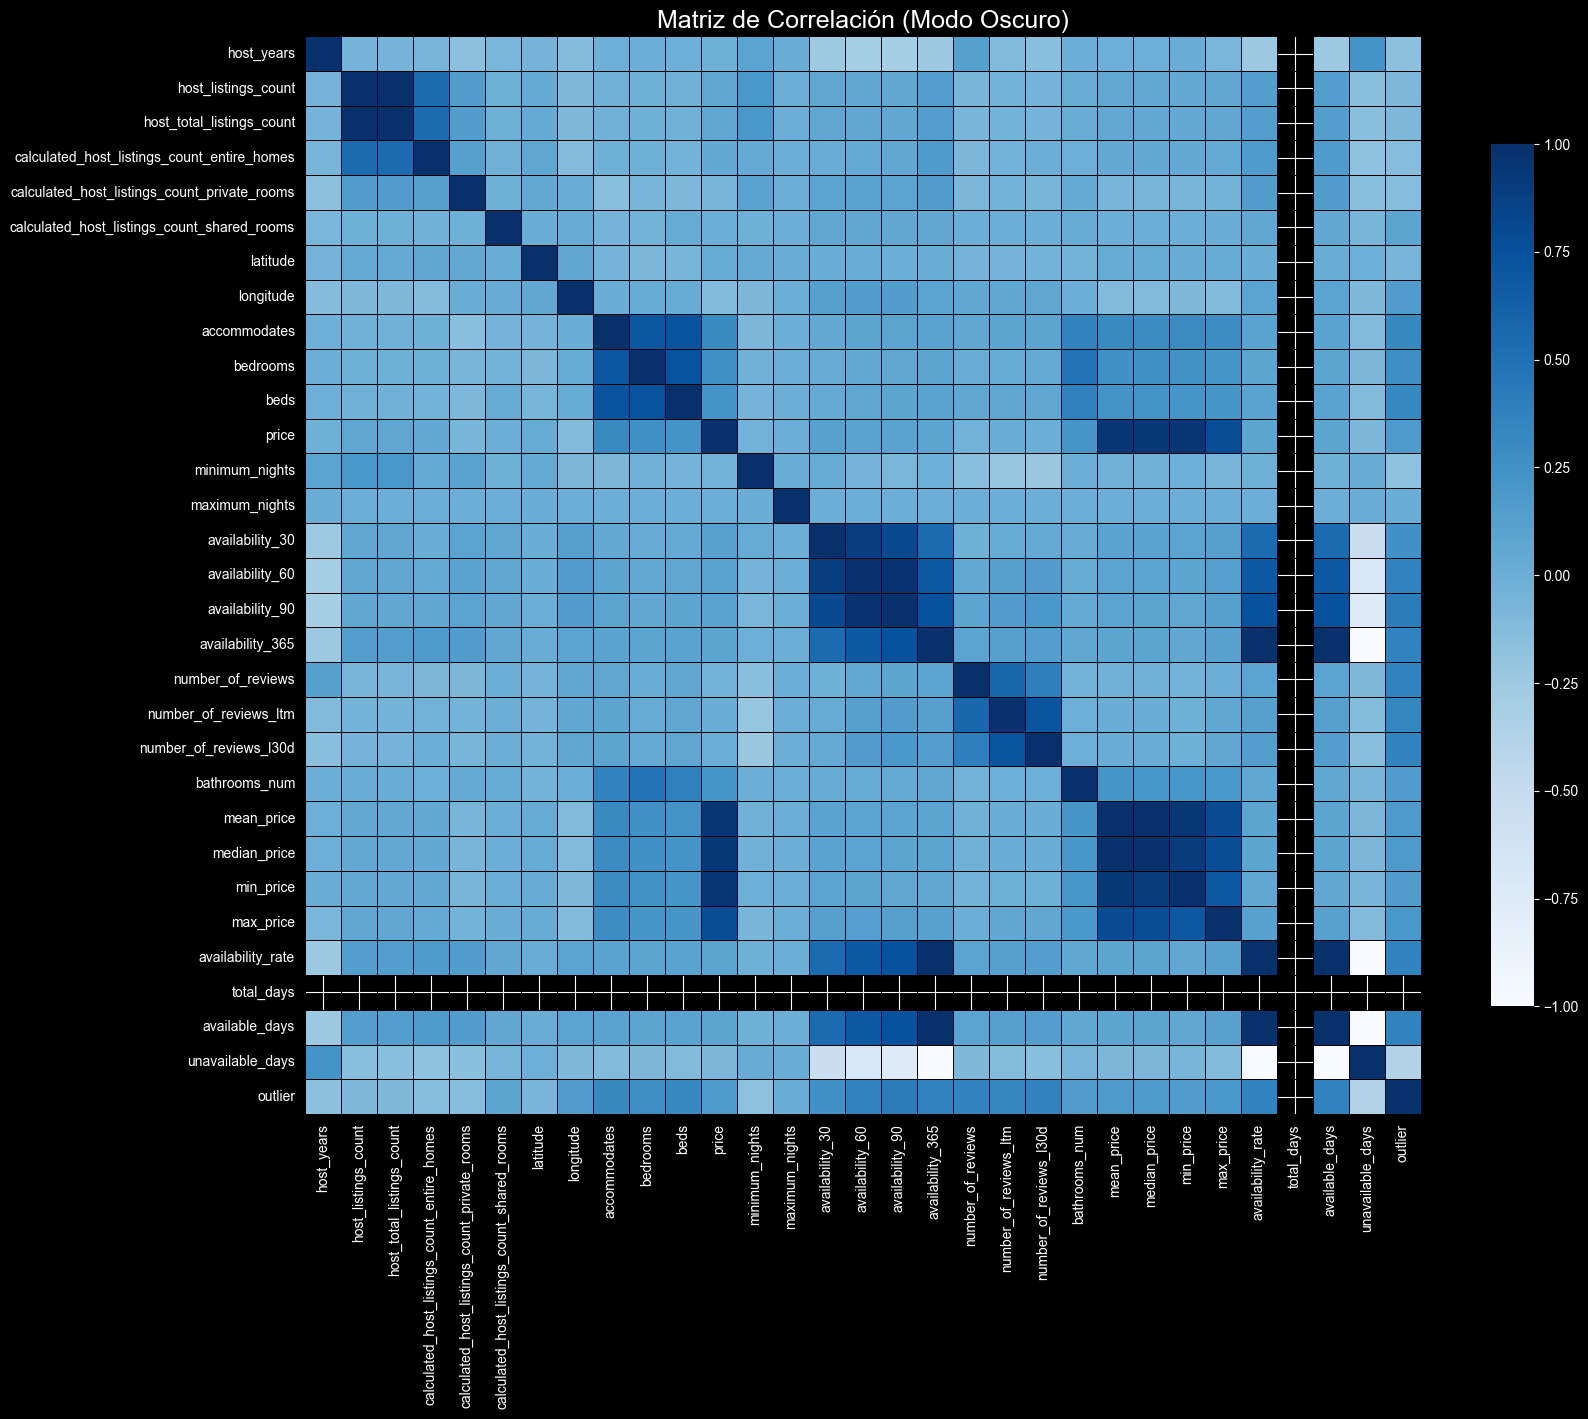


Columnas altamente correlacionadas (|corr| ≥ 0.85):
host_total_listings_count  <-->  host_listings_count   (corr = 1.000)
availability_60  <-->  availability_30   (corr = 0.892)
availability_90  <-->  availability_60   (corr = 0.971)
mean_price  <-->  price   (corr = 0.958)
median_price  <-->  price   (corr = 0.939)
median_price  <-->  mean_price   (corr = 0.993)
min_price  <-->  price   (corr = 0.955)
min_price  <-->  mean_price   (corr = 0.941)
min_price  <-->  median_price   (corr = 0.912)
availability_rate  <-->  availability_365   (corr = 1.000)
available_days  <-->  availability_365   (corr = 1.000)
available_days  <-->  availability_rate   (corr = 1.000)
unavailable_days  <-->  availability_365   (corr = -1.000)
unavailable_days  <-->  availability_rate   (corr = -1.000)
unavailable_days  <-->  available_days   (corr = -1.000)

Columnas sugeridas para eliminar por alta correlación:
{'availability_30', 'availability_rate', 'available_days', 'price', 'mean_price', 'availability_3

In [43]:
# ==========================================================
# 1. Selección de variables numéricas
# ==========================================================

numeric_cols = df_original.select_dtypes(include=[np.number]).columns.tolist()

# Opcional: excluir IDs
cols_to_exclude = ["id", "host_id"]
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

df_num = df_original[numeric_cols]

# ==========================================================
# 2. Calcular matriz de correlación
# ==========================================================

corr = df_num.corr()

# ==========================================================
# 3. Heatmap modo oscuro
# ==========================================================

plt.figure(figsize=(18, 14))
plt.style.use("dark_background")

sns.heatmap(
    corr,
    cmap="Blues",
    annot=False,
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"shrink": 0.8}
)

plt.title("Matriz de Correlación (Modo Oscuro)", fontsize=18)
plt.show()

# ==========================================================
# 4. Identificar columnas altamente correlacionadas
#    (Umbral: |corr| ≥ 0.85)
# ==========================================================

# Tomar solo la parte superior de la matriz (sin duplicados)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) >= 0.85
]

print("\nColumnas altamente correlacionadas (|corr| ≥ 0.85):")
for a, b, c in high_corr_pairs:
    print(f"{a}  <-->  {b}   (corr = {c:.3f})")

# ==========================================================
# 5. Lista de columnas candidatas para eliminar
#    (se conserva solo la primera de cada par)
# ==========================================================

cols_to_drop = set([b for a, b, c in high_corr_pairs])

print("\nColumnas sugeridas para eliminar por alta correlación:")
print(cols_to_drop)


Dado que existen columnas altamente correlacionadas, se eliminan. 

In [44]:
# Columnas que decidiste eliminar
cols_to_drop = {
    'availability_365', 'mean_price', 'host_listings_count', 'availability_30',
    'availability_rate', 'available_days', 'availability_60', 'price', 'median_price'
}

df_clean = df.drop(columns=cols_to_drop)
df_clean.shape

(38277, 39)

In [45]:
df.select_dtypes(include=[np.number]).columns.tolist()

['id',
 'host_id',
 'host_years',
 'host_listings_count',
 'host_total_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'latitude',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'bathrooms_num',
 'mean_price',
 'median_price',
 'min_price',
 'max_price',
 'availability_rate',
 'total_days',
 'available_days',
 'unavailable_days']

## <span style="color: rgb(138, 92, 245);">2. Escalar las variables con RobustScaler</span>

Dado los outliers ya estan relativamente tratados, se utiliza `StandardScaler` para escalar los datos y es un metodo que ayudará a una mejor eficiencia para el clustering con K-Means.

In [46]:
import pandas as pd

# ==============================
# 1. Selección de variables
# ==============================

variables_cluster = [
    'host_years',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'maximum_nights',
    'availability_90',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'bathrooms_num',
    'min_price',
    'max_price'
]

df_cluster = df[variables_cluster].copy()
df_cluster.head()

host_years  calculated_host_listings_count_entire_homes  \
0   17.216438                                            3   
1   16.972603                                            1   
2   16.813699                                            0   
3   16.813699                                            1   
4   16.736986                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             0   
2                                             2   
3                                             0   
4                                             1   

   calculated_host_listings_count_shared_rooms  accommodates  bedrooms  beds  \
0                                            0             1       1.0   1.0   
1                                            0             3       1.0   3.0   
2                                            0             2       1.0   1.0   
3                                            0             4       2.0   2.0   
4                                            0             2       1.0   1.0   

   minimum_nights  maximum_nights  availability_90  number_of_reviews  \
0              30            1125               63                 48   
1               1             730               18                409   
2              30             730               90                 50   
3               5            1125               12                  2   
4               2              14               34                507   

   number_of_reviews_ltm  number_of_reviews_l30d  bathrooms_num  min_price  \
0                      0                       0            1.0      150.0   
1                     32                       0            1.0       73.0   
2                      0                       0            1.0       60.0   
3                      1                       0            1.5      275.0   
4                     33                       2            1.0       68.0   

   max_price  
0      225.0  
1       79.0  
2       60.0  
3      275.0  
4       68.0

In [47]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

import numpy as np
X_scaled = np.nan_to_num(X_scaled)   # por si quedan NaN

X_scaled[:5]

array([[ 2.60464120e+00, -1.44171221e-01, -2.21520014e-01,
        -1.12389850e-01, -9.58487363e-01, -4.27831171e-01,
        -5.27577778e-01,  2.83239656e-01, -5.16265654e-03,
         8.34006413e-01,  4.89878297e-01, -3.42473491e-01,
        -3.62475532e-01, -3.46901025e-01, -1.99117012e-02,
         1.67844532e-02],
       [ 2.51990373e+00, -2.01352109e-01, -2.21520014e-01,
        -1.12389850e-01,  1.11196607e-01, -4.27831171e-01,
         1.36938287e+00, -6.97386340e-01, -5.19864014e-03,
        -4.57753530e-01,  7.65047039e+00,  1.83534897e+00,
        -3.62475532e-01, -3.46901025e-01, -2.90747540e-01,
        -3.00195963e-01],
       [ 2.46468156e+00, -2.29942554e-01, -1.75340830e-01,
        -1.12389850e-01, -4.23645378e-01, -4.27831171e-01,
        -5.27577778e-01,  2.83239656e-01, -5.19864014e-03,
         1.60906238e+00,  5.29549168e-01, -3.42473491e-01,
        -3.62475532e-01, -3.46901025e-01, -3.36473071e-01,
        -3.41446839e-01],
       [ 2.46468156e+00, -2.01352109e

# <span style="color: rgb(138, 92, 245);">IV. Número de Clusters Óptimo</span>

## Selección del número óptimo de clusters: Método del Codo y Silhouette

Para determinar el número óptimo de clusters en un análisis de clustering, se emplean comúnmente dos métricas complementarias:

1. **Método del Codo (Elbow Method)**  
   Este método evalúa la **inercia** o suma de las distancias al cuadrado de cada punto a su centroide dentro de cada cluster para distintos valores de *k*.  
   - Se grafica la inercia frente al número de clusters.  
   - El "codo" de la curva indica el punto donde agregar más clusters **ya no reduce significativamente la inercia**, sugiriendo un buen compromiso entre complejidad y ajuste de los datos.  
   - Ventaja: simple y rápido de calcular.  
   - Limitación: a veces el codo no es tan evidente, especialmente con datos muy dispersos o con clusters de tamaños muy diferentes.

2. **Silhouette Score**  
   Esta métrica mide **qué tan bien separado está cada cluster** y qué tan coherente es internamente:  
   - Valores cercanos a 1 indican clusters bien separados y homogéneos.  
   - Valores cercanos a 0 indican que los clusters se solapan.  
   - Valores negativos indican posibles asignaciones incorrectas de puntos a clusters.  
   - Se calcula para varios valores de *k* y se selecciona aquel que maximiza el Silhouette Score.  
   - Ventaja: proporciona una evaluación cuantitativa de la calidad de los clusters.

**Conclusión:**  
Usar ambos métodos juntos permite **tomar decisiones más robustas**:  
- El codo sugiere un rango razonable de *k* desde el punto de vista de inercia.  
- Silhouette Score valida la cohesión y separación real de los clusters, ayudando a elegir el número de clusters que representa mejor la estructura natural de los datos.


## <span style="color: rgb(138, 92, 245);">1. Método del Codo</span>

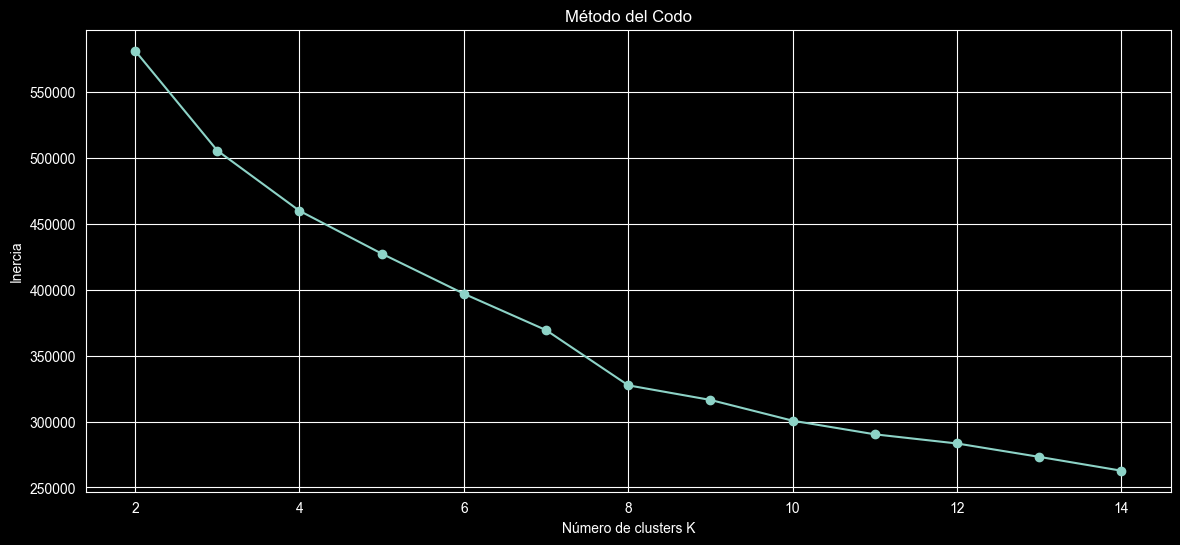

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(14,6))
plt.style.use("dark_background")
plt.plot(K, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters K")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()


## <span style="color: rgb(138, 92, 245);">2. Silhouette Score</span>

k=2 → Silhouette Score: 0.4657
k=3 → Silhouette Score: 0.3970
k=4 → Silhouette Score: 0.3709
k=5 → Silhouette Score: 0.3687
k=6 → Silhouette Score: 0.2138
k=7 → Silhouette Score: 0.2136
k=8 → Silhouette Score: 0.2009
k=9 → Silhouette Score: 0.2016
k=10 → Silhouette Score: 0.2041


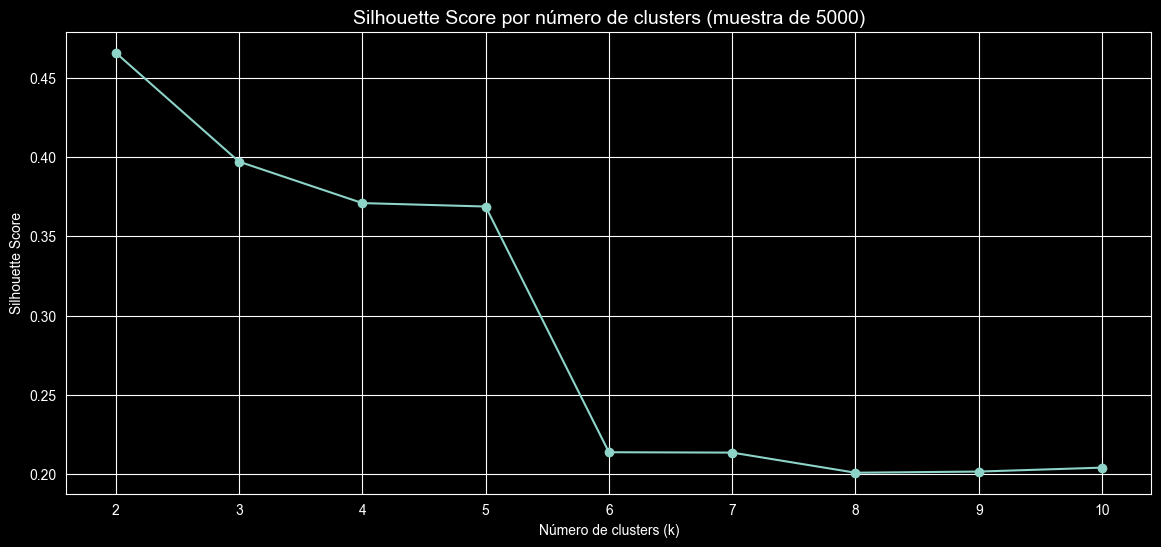

In [80]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ---------------------------------
# Convertir a DataFrame si es array
# ---------------------------------
if isinstance(X_scaled, np.ndarray):
    X_scaled = pd.DataFrame(X_scaled)

# -------------------------------
# 1. Tomar muestra de 5000 puntos
# -------------------------------
sample_size = 5000
if X_scaled.shape[0] > sample_size:
    X_sample = X_scaled.sample(sample_size, random_state=42)
else:
    X_sample = X_scaled.copy()

# -------------------------------
# 2. Evaluar Silhouette para varios k
# -------------------------------
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_sample)

    # Evitar error si solo asigna 1 cluster
    if len(np.unique(labels)) < 2:
        print(f"k={k} → No se puede calcular Silhouette (solo 1 cluster asignado)")
        silhouette_scores.append(np.nan)
        continue

    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"k={k} → Silhouette Score: {score:.4f}")

# -------------------------------
# 3. Gráfico estilo método del codo
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score por número de clusters (muestra de 5000)", fontsize=14)
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# <span style="color: rgb(138, 92, 245);">V. Clustering</span>

Tras evaluar los resultados de clustering con KMeans utilizando tanto el **método del codo** como el **Silhouette Score**, se decidió trabajar con **4 clusters** por las siguientes razones:

1. **Método del Codo:**  
   - Los resultados no son completamente claros, pues no se alcanza a percibir de forma clara un codo para determinar un número optimo de clustes. 

2. **Silhouette Score:**  
   - Aunque el máximo se alcanza en 2 clusters, la diferencia entre 3 y 4 clusters es pequeña, y ambos valores presentan una buena separación.  
   - Con 4 clusters, se obtiene una mejor distribución de puntos entre los clusters, evitando que un solo cluster concentre la mayoría de los datos y reflejando más claramente la heterogeneidad de los alojamientos.


In [73]:
k_opt = 4  # AJUSTAR

kmeans = KMeans(n_clusters=k_opt, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df["cluster"] = cluster_labels
df_cluster["cluster"] = cluster_labels


# <span style="color: rgb(138, 92, 245);">VI. Visualización de Grupos</span>

Para hacer una visualización de grupos mucho más fácil, se procede a aplicar PCA 2D. De esta manera, se podrá distingir de una manera gráfica los patrones de agrupamiento. 

In [74]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "cluster": cluster_labels
})

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="cluster",
    opacity=0.7,
    template="plotly_dark",
    title="Clustering visualizado con PCA 2D"
)

fig.update_traces(marker=dict(size=5))
fig.show()


Del gráfico anterior, se observa una distinción y segmentación muy clara de grupos. 

# <span style="color: rgb(138, 92, 245);">VII. Perfilamiento</span>

Finalmente, revisamos el contenido de cada cluster. 

In [75]:
perfil = df_cluster.groupby("cluster").mean().round(2)
perfil

host_years  calculated_host_listings_count_entire_homes  \
cluster                                                            
0              9.88                                         7.84   
1              8.37                                        26.44   
2              9.58                                         7.84   
3              9.09                                         4.03   

         calculated_host_listings_count_private_rooms  \
cluster                                                 
0                                                3.24   
1                                              208.13   
2                                                2.01   
3                                                3.30   

         calculated_host_listings_count_shared_rooms  accommodates  bedrooms  \
cluster                                                                        
0                                               0.05          2.32      1.11   
1                                               0.00          1.38      1.05   
2                                               0.02          6.42      2.72   
3                                               0.05          2.99      1.22   

         beds  minimum_nights  maximum_nights  availability_90  \
cluster                                                          
0        1.28           22.01        75741.00            29.92   
1        1.06           80.23          659.68            47.49   
2        3.56           18.82          656.37            41.51   
3        1.64            3.26          503.92            52.12   

         number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
cluster                                                                     
0                    13.28                   1.72                    0.18   
1                     1.16                   0.31                    0.02   
2                    18.71                   4.29                    0.49   
3                   111.06                  32.42                    3.46   

         bathrooms_num  min_price  max_price  
cluster                                       
0                 1.07     126.26     162.03  
1                 1.21      58.42      70.29  
2                 1.75     429.38     642.11  
3                 1.08     118.52     231.11

In [79]:
# Crear copia de df para análisis de clusters
df_cluster = df.copy()
df_cluster["cluster"] = cluster_labels
df["cluster"] = cluster_labels  # si también quieres mantenerlo en df original

# -------------------------------
# 3. Calcular tamaño y porcentaje de cada cluster
# -------------------------------
cluster_sizes = df_cluster["cluster"].value_counts().sort_index()
cluster_percentages = (cluster_sizes / len(df_cluster)) * 100

# -------------------------------
# 4. Crear tabla resumen con medias por cluster
# -------------------------------
cluster_summary = df_cluster.groupby("cluster").agg({
    "accommodates": "mean",
    "beds": "mean",
    "min_price": "mean",
    "max_price": "mean",
    "number_of_reviews": "mean",
    "bathrooms_num": "mean"
})

# Agregar columnas de conteo y porcentaje
cluster_summary["count"] = cluster_sizes
cluster_summary["percentage"] = cluster_percentages

# Reordenar columnas
cluster_summary = cluster_summary[
    ["count", "percentage", "accommodates", "beds", "min_price",
     "max_price", "number_of_reviews", "bathrooms_num"]
]

# -------------------------------
# 5. Mostrar resumen final
# -------------------------------
cluster_summary.round(2)

count  percentage  accommodates  beds  min_price  max_price  \
cluster                                                                
0        29137       76.12          2.32  1.28     126.26     162.03   
1         1210        3.16          1.38  1.06      58.42      70.29   
2         4082       10.66          6.42  3.56     429.38     642.11   
3         3848       10.05          2.99  1.64     118.52     231.11   

         number_of_reviews  bathrooms_num  
cluster                                    
0                    13.28           1.07  
1                     1.16           1.21  
2                    18.71           1.75  
3                   111.06           1.08

El modelo de 4 clusters ofrece una segmentación granular y muy relevante para perfilamiento, revelando un segmento adicional de alojamientos medianos con alta demanda. Este cluster intermedio aporta valor estratégico y mejora la interpretabilidad de los segmentos.  A continuación se presenta una descripción clara de cada grupo, considerando su tamaño relativo y sus características promedio.

### Cluster 0 — Oferta Estándar Dominante (76.12%)

Tamaño: 76.12% del total
Precio promedio: $126–$162
Capacidad: 2 huéspedes
Camas: 1–2
Baños: 1
Reseñas promedio: 13

Este es el grupo mayoritario y representa la oferta típica del mercado: listings económicos o de gama media, para estadías cortas, con infraestructura básica y demanda moderada. Es el “perfil estándar” del mercado.

### Cluster 1 — Unidades Económicas y de Baja Rotación (3.16%)

Tamaño: 3.16%
Precio promedio: $58–$70
Capacidad: 1 huésped
Camas: 1
Baños: 1
Reseñas promedio: 1–2

Este cluster agrupa listings muy económicos, generalmente para una sola persona, con baja actividad de reseñas y probablemente menor visibilidad. Son opciones básicas, probablemente habitaciones pequeñas o estudios muy simples.

### Cluster 2 — Alojamiento Premium de Alta Capacidad (10.66%)

Tamaño: 10.66%
Precio promedio: $429–$642
Capacidad: 6 huéspedes
Camas: 3–4
Baños: ~1.7
Reseñas promedio: 19

Este grupo representa propiedades grandes y de gama alta, adecuadas para grupos y estadías más largas.
Son listings significativamente más caros y con mayor infraestructura, lo que sugiere propiedades completas o de lujo. No son muchas en número, pero ocupan un nicho premium dentro del mercado.

### Cluster 3 — Propiedades de Capacidad Media con Alta Actividad (10.05%)

Tamaño: 10.05%
Precio promedio: $118–$231
Capacidad: 3 huéspedes
Camas: 1–2
Baños: 1
Reseñas promedio: 111

Este cluster destaca por tener la mayor cantidad de reseñas, lo que sugiere:

alta ocupación,

buena demanda,

propiedades bien posicionadas.

Son listings accesibles en precio, con capacidad media y muy activos en el mercado. Representan alojamientos probablemente con excelente ubicación o buena relación calidad–precio.

### Resumen General

| Cluster | Descripción general                    | % del total |
| ------- | -------------------------------------- | ----------- |
| **0**   | Oferta estándar, económica–media       | **76%**     |
| **1**   | Unidades muy económicas, baja rotación | **3%**      |
| **2**   | Propiedades premium de alta capacidad  | **10%**     |
| **3**   | Capacidad media con alta demanda       | **10%**     |


# <span style="color: rgb(138, 92, 245);">VIII. Conclusiones</span>

1. **Estructura del mercado claramente segmentada**  
   El análisis reveló **cuatro clusters distintos**, con características bien diferenciadas en términos de precio, capacidad, número de camas y actividad de reseñas. Esto indica que el mercado no es homogéneo y que existen nichos bien definidos.

2. **Cluster mayoritario (Cluster 0) representa la oferta estándar**  
   La mayoría de los listings (76%) se concentra en un perfil económico–medio, con baja capacidad y precios moderados. Este grupo refleja la oferta típica y más frecuente en la plataforma.

3. **Identificación de segmentos nicho**  
   - **Cluster 1:** unidades muy económicas y con poca actividad (3%), probablemente habitaciones individuales o estudios pequeños.  
   - **Cluster 2:** propiedades premium de alta capacidad (11%), dirigidas a grupos o familias, con precios significativamente más altos.  
   - **Cluster 3:** alojamientos de capacidad media pero con **alta demanda y actividad** (10%), indicando propiedades muy visitadas o con buena reputación.

4. **Información estratégica para perfilamiento y marketing**  
   La segmentación permite:  
   - Ajustar estrategias de **precios y promociones** según tipo de alojamiento.  
   - Identificar nichos **rentables o con alta rotación**.  
   - Mejorar la **asignación de recursos** para gestión de listings y recomendaciones.
